# Cross Comparison

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

from uncertainty_motion_prediction.dataloader import Dataloader
dataset=Dataloader();

pretrained_path="./pretrained/"

In [2]:
from uncertainty_motion_prediction.predictor import ConstantVelocityPredictor

def get_cvm_pred(dataset_index, dt):
    return ConstantVelocityPredictor(N_future=4, dt=dt)

In [3]:
from uncertainty_motion_prediction.predictor import ConstantVelocityKFPredictor

def get_kf_pred(dataset_index, dt):
    return  ConstantVelocityKFPredictor(N_future=4, dt=dt)

In [4]:
from uncertainty_motion_prediction.predictor import (
    HMMMultinomialFirstOrder, HMMLatentSegmentsExtractor, KMeansOutcome, HMMLatentSegmentsPredictor
)
from uncertainty_motion_prediction.predictor.hmm_latent_segments import (
    segmentize_trajectory, normalise_segment, normalise_segment_batch
)

def get_hmm_pred(dataset_index, dt):
    clustering = KMeansOutcome.load_from_file(pretrained_path + "hmm_segment_clustering_%d.pickle" %dataset_index)
    state_dim = 50
    hmm = HMMMultinomialFirstOrder(state_dim, clustering.N, verbose=True, max_iters=3)
    hmm.load_from_file(pretrained_path + "hmm_model_param_%d.pickle" %dataset_index)
    return HMMLatentSegmentsPredictor(hmm, clustering)
def get_hmm_test_traj(traj_dataset):
    segment_length = 4
    num_segment = 4
    num_history_segment = 3
    traj_length = num_segment * (segment_length - 1) + 1
    history_traj_length = num_history_segment * (segment_length - 1) + 1
    return traj_dataset.get_trajlets(
            length=traj_length * 0.4,
            overlap=1,
            to_numpy=True), history_traj_length
    

In [5]:
from fitter import Fitter, get_common_distributions, get_distributions

from uncertainty_motion_prediction.predictor import (
    HMMMultinomialFirstOrder, HMMLatentSegmentsExtractor, KMeansOutcome, HMMLatentSegmentsPredictor
)
from uncertainty_motion_prediction.predictor import HMMContinuousEmissionsPredictor

from uncertainty_motion_prediction.predictor.hmm_continuous_emissions import normalise_segment_batch

def get_ghmm_pred(dataset_index, dt):
    model = None
    with open(pretrained_path + 'gaussian_hmm_%s.pkl'%dataset_index, 'rb') as file:
        model = pickle.load(file)
    return HMMContinuousEmissionsPredictor(hmm = model)

def get_ghmm_test_traj(traj_dataset):
    segment_length = 4
    num_segment = 4# Hidden Markov Model with Gaussian emissions (to model trajectory observations)
    return traj_dataset.get_trajlets(
            length=segment_length * num_segment * 0.4,
            overlap=1,
            to_numpy=True), None
    

In [6]:
from uncertainty_motion_prediction.evaluators import DistanceErrorEvaluator

algos =[['cvm', get_cvm_pred,None],
        ['kf' , get_kf_pred,None],
        ['hmm' ,get_hmm_pred,get_hmm_test_traj],
        ['ghmm' ,get_ghmm_pred,get_ghmm_test_traj],
]

In [7]:
res = []

for i in range(len(dataset.get_key())):
    traj_dataset = dataset.load(i)
   
    res_algos ={}
    for pred in algos:
        if pred[2] is None:
            trajlets  = traj_dataset.get_trajlets(length=4.8, to_numpy=True)
            evaluator = DistanceErrorEvaluator(N_future=4)
        else:
            # for hmm and ghmm
            get_test_dataset = pred[2]
            trajlets, hist_length = get_test_dataset(traj_dataset)
            evaluator = DistanceErrorEvaluator(N_future=4, N_history=hist_length)
        
        dt = trajlets[0, 1, 4] - trajlets[0, 0, 4]
        predictor = pred[1](i, dt =dt)
        
        evaluator.evaluate(predictor, trajlets)
        res_algos.update({pred[0]:evaluator.statistic()})
    res.append([dataset.get_key()[i], res_algos])
        

/home/kurisu/nus-cs5340/uncertainty-motion-prediction/src/uncertainty_motion_prediction/predictor/hmm_continuous_emissions.py:30: RuntimeWarning: invalid value encountered in true_divide
  x, y = dir / np.linalg.norm(dir)
/home/kurisu/nus-cs5340/uncertainty-motion-prediction/src/uncertainty_motion_prediction/predictor/hmm_continuous_emissions.py:30: RuntimeWarning: invalid value encountered in true_divide
  x, y = dir / np.linalg.norm(dir)
/home/kurisu/nus-cs5340/uncertainty-motion-prediction/src/uncertainty_motion_prediction/predictor/hmm_continuous_emissions.py:30: RuntimeWarning: invalid value encountered in true_divide
  x, y = dir / np.linalg.norm(dir)
/home/kurisu/nus-cs5340/uncertainty-motion-prediction/src/uncertainty_motion_prediction/predictor/hmm_continuous_emissions.py:30: RuntimeWarning: invalid value encountered in true_divide
  x, y = dir / np.linalg.norm(dir)
/home/kurisu/nus-cs5340/uncertainty-motion-prediction/src/uncertainty_motion_prediction/predictor/hmm_continuous

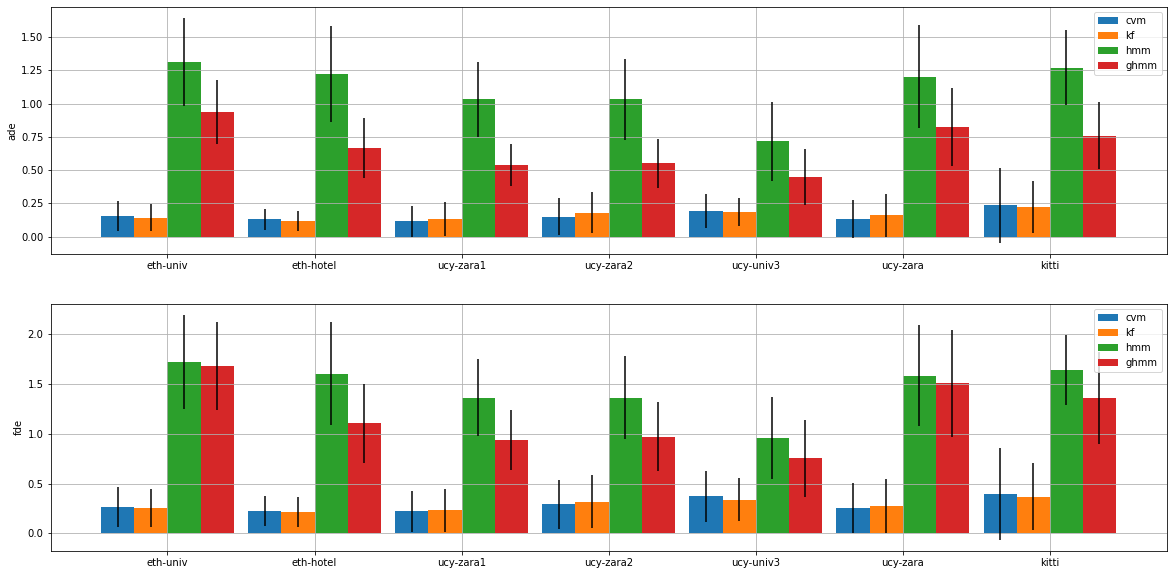

In [8]:
metrices  = evaluator.get_metrics()

fig, axs = plt.subplots(len(metrices),1, figsize=(20, 10))
labels = dataset.get_key()
x = np.arange(len(labels))

width = 0.3/len(algos) * 3

for m_index in range(len(metrices)):
    m  = metrices[m_index]
    axs[m_index].set_ylabel(m)
    name = []
    
    for algo_index in range(len(algos)):
        algo = algos[algo_index]
        value =[]
        std = []
        for i in res:
            value.append(i[1][algo[0]][m][0])
            std.append(i[1][algo[0]][m][1])
            
        axs[m_index].bar(x +  (width * (float(algo_index + 0.5)-float(len(algos))/2.0) ) , 
                         value, width, label=algo[0],yerr=std)
        
    axs[m_index].set_xticks(x)
    axs[m_index].set_xticklabels(labels)
    axs[m_index].legend()
    axs[m_index].grid()


        